#  Chapter 20: Examples 2

Since we have covered the deeper features of the *Music21Object*, let's try analyze pieces and repertories of music using this information.

In [24]:
from music21 import *

## Picardy-less Bach endings

J.S. Bach usually ends pieces in minor with a major chord, generally called a **“Picardy third,”**(皮卡第三和弦) but does he ever end pieces in minor?

Let’s look through the chorales to find out

In [2]:
# get all the pieces by Bach
corpus.search('bach')

<music21.metadata.bundles.MetadataBundle {564 entries}>

Since I happen to know that all the Bach pieces are *.xml* or compressed *.xml (.mxl)* files, we can limit just to those

In [3]:
corpus.search('bach', fileExtensions='xml')

<music21.metadata.bundles.MetadataBundle {412 entries}>

But before we work on a whole repertory, let’s work with a single piece, the first one from the search

In [4]:
chorales = corpus.search('bach', fileExtensions='xml')
chorales[0]

<music21.metadata.bundles.MetadataEntry 'bach_bwv1_6_mxl'>

In [5]:
bwv1 = chorales[0].parse()
bwv1.measures(0, 3).show('xml')

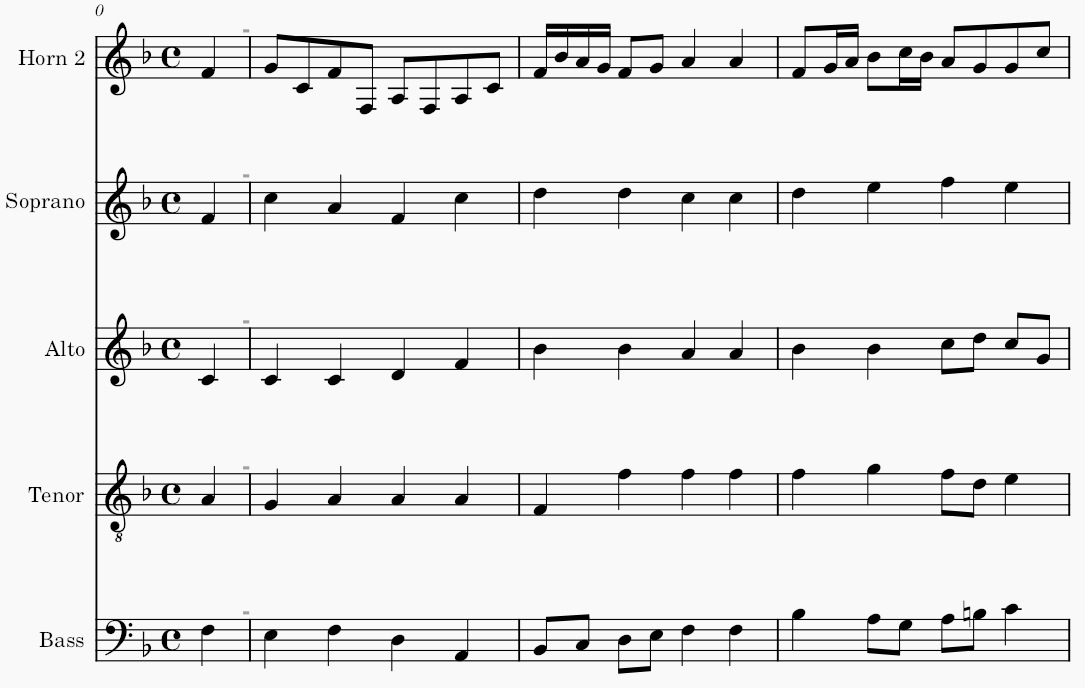

that looks like it’s going to be in major, so check it out.

In [6]:
bwv1.analyze('key')

<music21.key.Key of F major>

Let’s parse a few pieces and find one in minor

In [7]:
for i, chorale in enumerate(chorales[:20]):
    cScore = chorale.parse()
    if cScore.analyze('key').mode == 'minor':
        print(i, chorale)

1 <music21.metadata.bundles.MetadataEntry 'bach_bwv10_7_mxl'>
2 <music21.metadata.bundles.MetadataEntry 'bach_bwv101_7_mxl'>
3 <music21.metadata.bundles.MetadataEntry 'bach_bwv102_7_mxl'>
4 <music21.metadata.bundles.MetadataEntry 'bach_bwv103_6_mxl'>
6 <music21.metadata.bundles.MetadataEntry 'bach_bwv108_6_mxl'>
8 <music21.metadata.bundles.MetadataEntry 'bach_bwv110_7_mxl'>
9 <music21.metadata.bundles.MetadataEntry 'bach_bwv111_6_mxl'>
12 <music21.metadata.bundles.MetadataEntry 'bach_bwv113_8_mxl'>
13 <music21.metadata.bundles.MetadataEntry 'bach_bwv114_7_mxl'>


Then let's grab BWV 10 to analyze

In [8]:
bwv10 = corpus.parse('bwv10')
bwv10.measures(0, 5).show('xml')

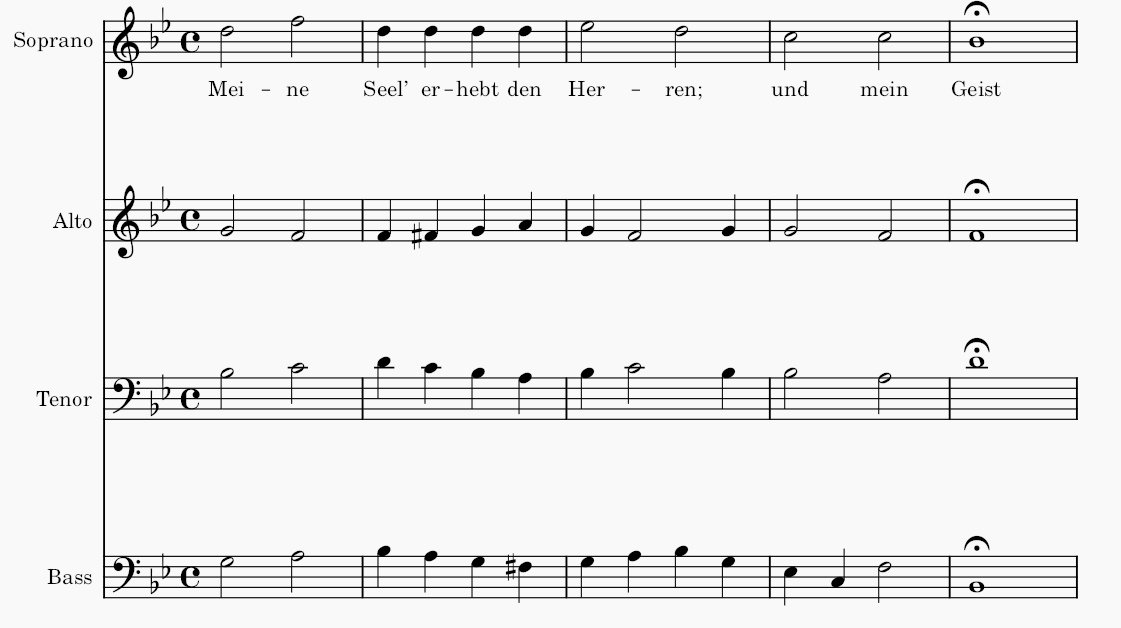

Looks like it’s in G minor with a first cadence on B-flat. Let’s look at the end also

In [9]:
soprano = bwv10.parts[0]
len(soprano.getElementsByClass('Measure'))

22

In [10]:
#  let’s grab just the final two measures 21 and 22
bwv10.measures(21, 22).show('xml')

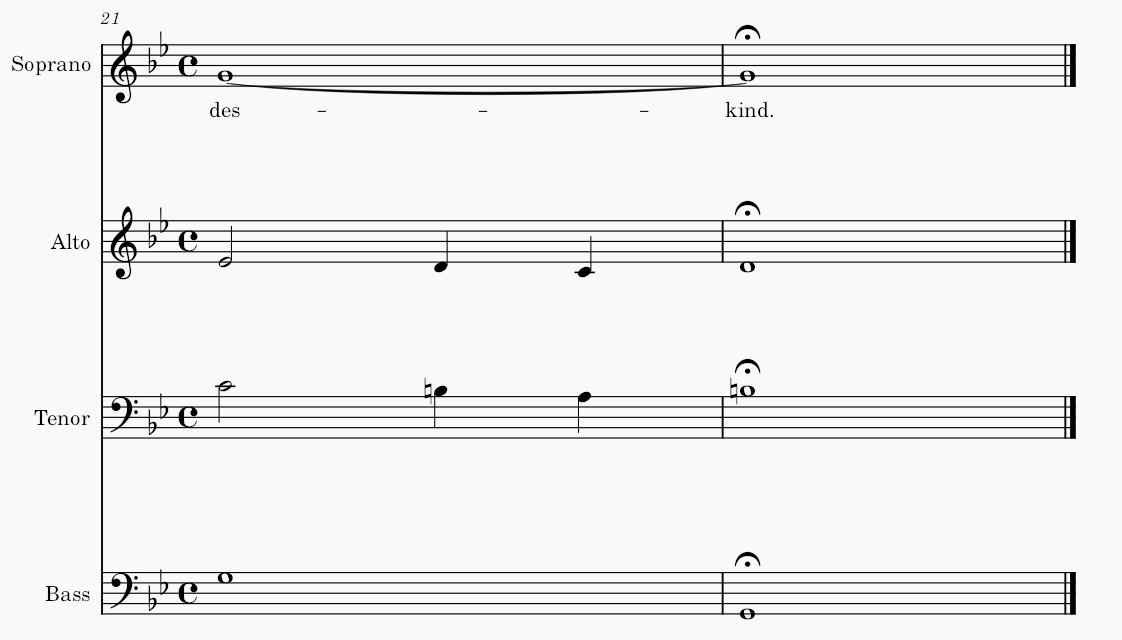

Looks like a nice **Picardy third** here. let’s see if *music21* can figure out that it’s a major chord

In [11]:
# get the last pitch from each part
lastPitches = []

for part in bwv10.parts:
    lastPitch = part.pitches[-1]
    lastPitches.append(lastPitch)

lastPitches

[<music21.pitch.Pitch G4>,
 <music21.pitch.Pitch D4>,
 <music21.pitch.Pitch B3>,
 <music21.pitch.Pitch G2>]

let’s make a chord out of those pitches

In [12]:
c = chord.Chord(lastPitches)
c.duration.type = 'whole'
c.show('xml')

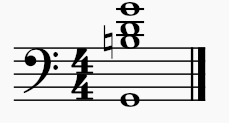

This could get ugly so let's put it in closed position

In [13]:
cClosed = c.closedPosition()
cClosed.show('xml')

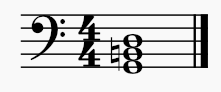

Well, that looks like a G-major chord to me. But can music21 tell what it is?

In [14]:
cClosed.isMajorTriad()

True

In [15]:
cClosed.root()

<music21.pitch.Pitch G2>

Check for the chords that end on the same root pitched as the analyzed key

In [16]:
bwv10.analyze('key').tonic.name

'G'

In [19]:
cClosed.root().name

'G'

Let’s look through the whole repertory and look for the exceptions

In [20]:
#  First the function to get the last chord from a score
def getLastChord(score):
    lastPitches = []

    for part in score.parts:
        lastPitch = part.pitches[-1]
        lastPitches.append(lastPitch)

    c = chord.Chord(lastPitches)
    c.duration.type = 'whole'

    cClosed = c.closedPosition()
    return cClosed

In [21]:
# trying it on BWV 10
getLastChord(bwv10)

<music21.chord.Chord G2 B2 D3>

now let’s write a routine that takes in a score and sees if it is relevant

1.in minor

2.have a major last chord

3.have the root of the last chord be the same as the tonic of the analyzed key

In [22]:
# return False if the piece is not relevant, but return the last chord if it is
def isRelevant(score):
    analyzedKey = score.analyze('key')
    if analyzedKey.mode != 'minor':
        return False
    lastChord = getLastChord(score)
    if lastChord.isMinorTriad() is False:
        return False
    if lastChord.root().name != analyzedKey.tonic.name:
        return False
    else:
        return lastChord

let’s look through some pieces and see which are relevant

In [26]:
relevantStream = stream.Stream()
relevantStream.append(meter.TimeSignature('4/4'))

for chorale in chorales:
    score = chorale.parse()
    falseOrChord = isRelevant(score)
    if falseOrChord is not False:
        theChord = falseOrChord  # rename for clarity
        theChord.lyric = score.metadata.title
        relevantStream.append(theChord)

relevantStream.show('xml')

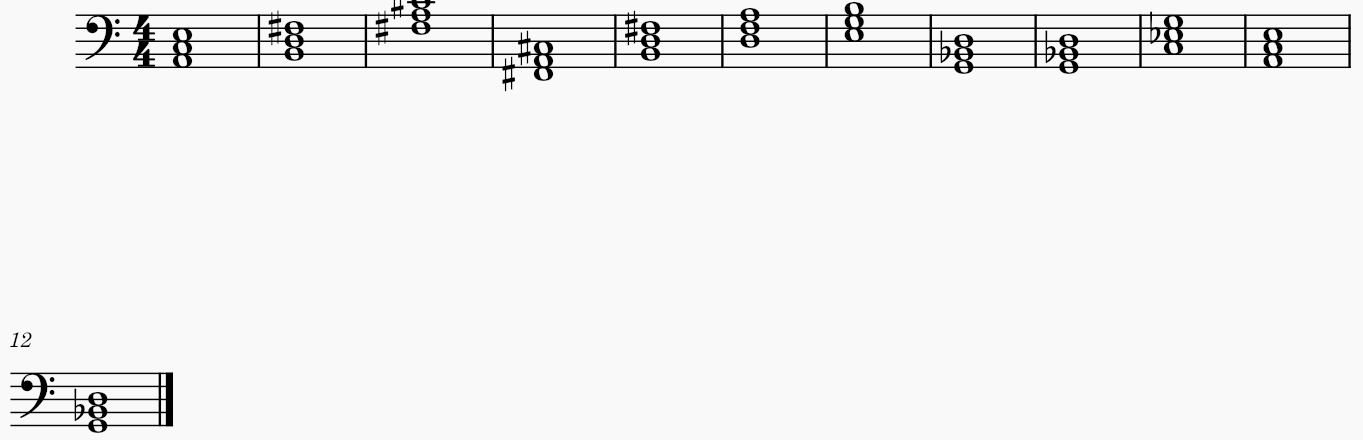

Here is a mistake that the lyrics doesn't show correctly

But anyway this is a great example of real musical research.

## Gap-Fill analysis

the concept of **“Gap-Fill”**: after a large leap in the melody, the listener expects that the following motion will be in the opposite direction, thereby filling the gap that was just created.

Let us see if there is a real Gap Fill or just regression to the mean in one piece of early fifteenth century music, using *Interval* objects as a guide

In [27]:
luca = corpus.parse('luca/gloria')
luca.measures(1, 7).show('xml')

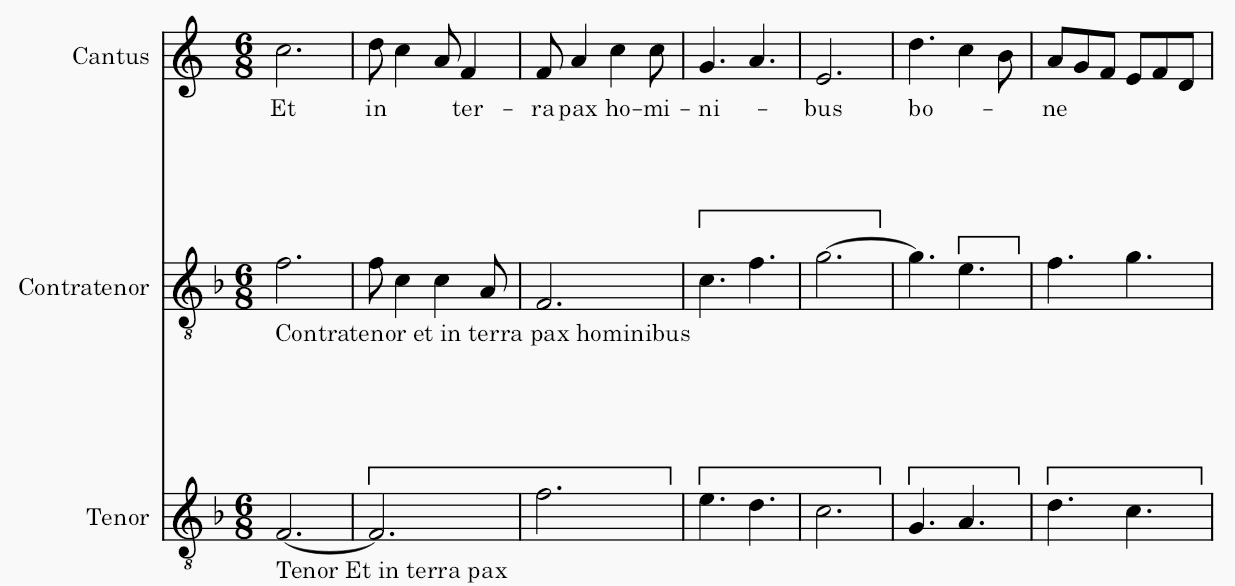

For now, let’s look at the top part alone

In [28]:
cantus = luca.parts['Cantus']
cantus.measures(1, 20).show('xml')

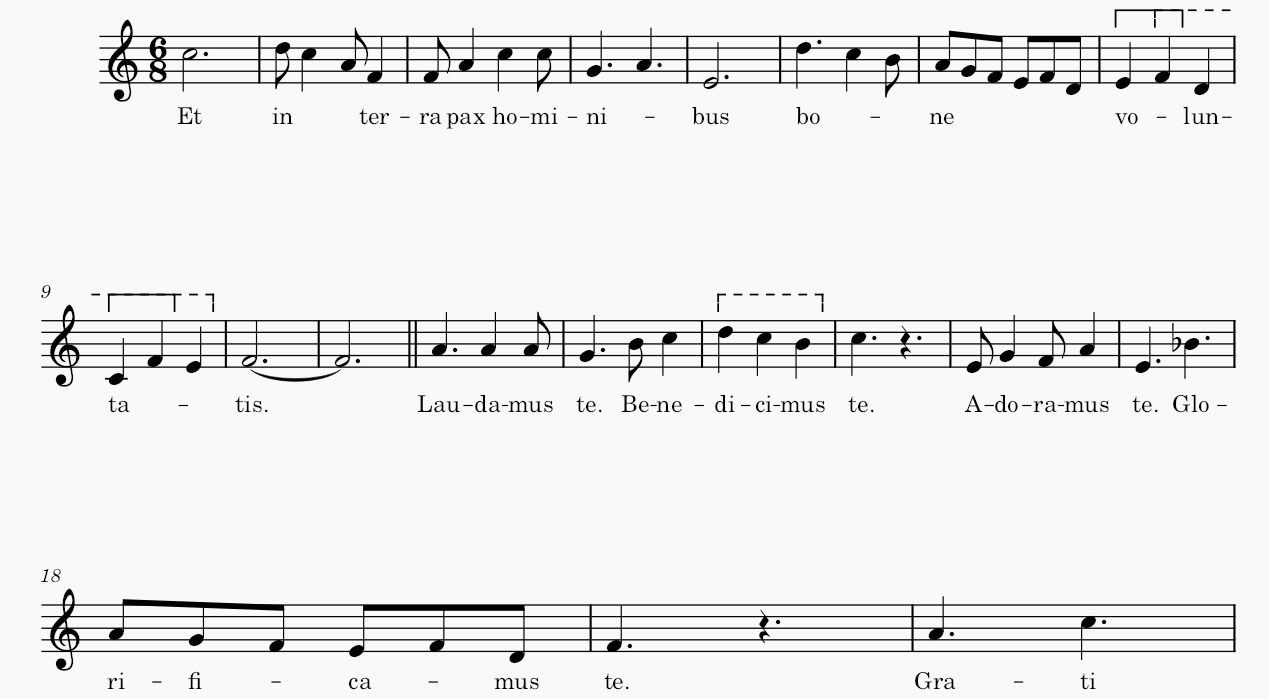

Let us figure out the average pitch height

In [29]:
# getting the average of the .ps value, where Middle C = 60(similar to .midi value)
totalNotes = 0
totalHeight = 0
for n in cantus.recurse().getElementsByClass('Note'):
    totalNotes += 1
    totalHeight += n.pitch.ps
averageHeight = totalHeight/totalNotes
averageHeight

67.41100323624596

We can figure out approximately what note that is by creating a new *Note* object

In [30]:
averageNote = note.Note()
averageNote.pitch.ps = round(averageHeight)
averageNote.show('xml')

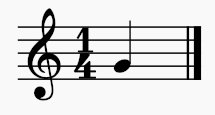

Python has some even easier ways to get the average pitch

In [31]:
import statistics
statistics.mean([p.ps for p in cantus.pitches])

67.41100323624596

In [33]:
totalNotes = 0
totalHeight = 0
for n in cantus.pitches:
    totalNotes += 1
    totalHeight += n.ps
averageHeight = totalHeight/totalNotes
averageHeight

67.41100323624596

In [34]:
statistics.median([p.ps for p in cantus.pitches])

67.0

**Medians** are usually more useful than means in doing statistical analysis

In [35]:
medianHeight = statistics.median([p.ps for p in cantus.pitches])

now let us get all the intervals in a piece

In [37]:
allIntervals = []
for n in cantus.recurse().getElementsByClass('Note'):
    nextNote = n.next('Note')
    if nextNote is None: # last note of the piece
        continue
    thisInterval = interval.Interval(n, nextNote)
    allIntervals.append(thisInterval)

Let’s look at some of the intervals

In [38]:
allIntervals[0:5]

[<music21.interval.Interval M2>,
 <music21.interval.Interval M-2>,
 <music21.interval.Interval m-3>,
 <music21.interval.Interval M-3>,
 <music21.interval.Interval P1>]

In [39]:
len(allIntervals)

308

In [40]:
len(cantus.recurse().getElementsByClass('Note'))

309

it makes sense that if there are 309 notes there would be 308 intervals

Let’s look at that first Interval object in a bit more detail

In [48]:
firstInterval = allIntervals[0]
firstInterval.noteStart

<music21.note.Note C>

In [49]:
firstInterval.noteEnd

<music21.note.Note D>

In [50]:
firstInterval.direction

<Direction.ASCENDING: 1>

see whether gap-fill or regression to the mean is happening at any given moment

If the line leaps up and is below the mean then the ***gap-fill*** hypothesis would predict **downward** motion

but the ***regression to the mean*** hypothesis would predict **upward** motion for the next interval

In [51]:
# define a function that test whether the gap-fill and regression hypotheses predict different motions
def relevant(thisInterval):
    if thisInterval.generic.undirected < 3:
        return False
    noteEndPs = thisInterval.noteEnd.pitch.ps
    if thisInterval.direction == interval.Direction.ASCENDING and noteEndPs < medianHeight:
        return True
    elif thisInterval.direction == interval.Direction.DESCENDING and noteEndPs > medianHeight:
        return True
    else:
        return False

In [52]:
[relevant(i) for i in allIntervals].count(True)

22

There won’t be too many relevant intervals in the piece

In [53]:
[relevant(i) for i in allIntervals[0:10]]

[False, False, True, False, False, False, False, False, False, False]

The third interval is relevant. Let’s review what that interval is

It’s the C5 descending to A4, still above the average note G4.

Gap-fill predicts that the next note should be higher, regression predicts that it should be lower

In [54]:
cantus.measures(1, 3).show('xml')

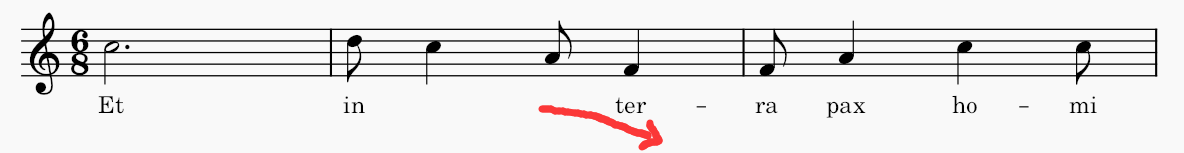

In this case, the **regression to the mean** hypothesis is correct and the gap-fill hypothesis is wrong

But that’s just one case,let us write a function that takes in a relevant interval and the following interval and says whether gap-fill or regression is correct

In [55]:
# 1 if gap-fill is correct, 2 if regression is correct
def whichHypothesis(firstInterval, secondInterval):
    if secondInterval.direction == interval.Direction.OBLIQUE:
        return 0
    elif secondInterval.direction != firstInterval.direction:
        return 1
    else:
        return 2

In [56]:
whichHypothesis(allIntervals[2], allIntervals[3])

2

We can run this analysis on the small dataset of 32 relevant intervals in the cantus part

In [57]:
# the [] containing the number of oblique intervals, the number that fit the gap-fill hypothesis, and the number which fit the regression hypothesis
obliqueGapRegression = [0, 0, 0]

for i in range(len(allIntervals) - 1):
    thisInterval = allIntervals[i]
    nextInterval = allIntervals[i + 1]
    if not relevant(thisInterval):
        continue
    hypothesis = whichHypothesis(thisInterval, nextInterval)
    obliqueGapRegression[hypothesis] += 1

obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

# for this small set of data, gap-fill is more predictive than regression

([6, 10, 6], 4)

Let’s run it on the whole piece

In [58]:
# First redefine "relevant" to take the average pitch height as a parameter
def relevant2(thisInterval, medianHeight):
    if thisInterval.generic.undirected < 3:
        return False
    noteEndPs = thisInterval.noteEnd.pitch.ps
    if thisInterval.direction == interval.Direction.ASCENDING and noteEndPs < medianHeight:
        return True
    elif thisInterval.direction == interval.Direction.DESCENDING and noteEndPs > medianHeight:
        return True
    else:
        return False

let’s define a function that computes hypothesisTotal for a single part

In [59]:
def onePartHypothesis(part):
    obliqueGapRegression = [0, 0, 0]

    medianHeight = statistics.median([p.ps for p in part.pitches])
    allIntervals = []
    for n in part.recurse().getElementsByClass('Note'):
        nextNote = n.next('Note')
        if nextNote is None: # last note of the piece
            continue
        thisInterval = interval.Interval(n, nextNote)
        allIntervals.append(thisInterval)

    for i in range(len(allIntervals) - 1):
        thisInterval = allIntervals[i]
        nextInterval = allIntervals[i + 1]
        if not relevant2(thisInterval, medianHeight):
            continue
        hypothesis = whichHypothesis(thisInterval, nextInterval)
        obliqueGapRegression[hypothesis] += 1

    return obliqueGapRegression

When I refactor, I always make sure that everything is still working as before

In [60]:
onePartHypothesis(cantus)

[6, 10, 6]

Looks good! Now we’re ready to go

In [61]:
obliqueGapRegression = [0, 0, 0]

for p in luca.parts:
    onePartTotals = onePartHypothesis(p)
    obliqueGapRegression[0] += onePartTotals[0]
    obliqueGapRegression[1] += onePartTotals[1]
    obliqueGapRegression[2] += onePartTotals[2]

obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

([7, 20, 28], -8)

The lower two parts overwhelm the first part and it is looking like **regression to the mean** is ahead

But it’s only one piece! Let’s see if there are other similar pieces in the corpus

In [62]:
# There’s a collection of works from the 14th century, mostly Italian works
corpus.search('trecento')

<music21.metadata.bundles.MetadataBundle {103 entries}>

Let’s run 20 of them through this search and see how they work

In [63]:
obliqueGapRegression = [0, 0, 0]

for trecentoPieceEntry in corpus.search('trecento')[:20]:
    parsedPiece = trecentoPieceEntry.parse()
    for p in parsedPiece.parts:
        onePartTotals = onePartHypothesis(p)
        obliqueGapRegression[0] += onePartTotals[0]
        obliqueGapRegression[1] += onePartTotals[1]
        obliqueGapRegression[2] += onePartTotals[2]

obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

([27, 86, 84], 2)

So it looks like neither the gap-fill hypothesis or the regression to the mean hypothesis are sufficient in themselves to explain melodic motion in this repertory

These two examples maybe hard to understand especailly for those professional musical analysis.

But the power of corpus analysis with *music21* can help you do whatever you want, so try it by yourself !!!